## Load JEPA model and sample data

In [1]:
import sys
sys.path.append('/home/rafik/Documents/InnoUni/ai_lab/Sym-JEPA')

In [2]:
from src.model import SymJEPA


jepa = SymJEPA(tokenization='octuple', pass_target_mask_to_predictor=True).cuda()

/home/rafik/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pe add global time
pe add modulo time
pe add idx


In [3]:
import torch

ckpt_path = '/home/rafik/attn-masks.ckpt'

ckpt_path = '/home/rafik/info_nce.ckpt'

jepa.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [4]:
import os
from glob import glob

midi_files = glob(os.path.join("/home/rafik/Documents/InnoUni/ai_lab/Sym-JEPA/dataset/clean_midi/", "**/*.mid"), recursive=True)[:100]

print([os.path.basename(f) for f in midi_files])

['If I Said You Had a Beautiful Body (Would You Hold It Against Me).mid', 'I Need More of You.mid', 'Let Your Love Flow.1.mid', 'Let Your Love Flow.mid', 'Crossfire.mid', 'On a Summer Night.mid', 'Rode schoentjes.mid', 'Sacramento.mid', 'Chirpy Chirpy Cheep Cheep.1.mid', 'Chirpy Chirpy Cheep Cheep.mid', 'Sacramento.1.mid', 'Freestyler.mid', 'Little Girl.mid', 'Tangerine.mid', 'Come Rain or Come Shine.mid', 'Who Can It Be Now.mid', 'Who Can It Be Now.1.mid', 'Down Under.mid', 'Down Under.1.mid', 'Nocturne for piano No. 8 (9) in E minor, H46b.mid', 'Nocturne in F: No.6 H40.mid', 'Santa Monica.1.mid', 'Santa Monica.mid', 'I Will Buy You a New Life.mid', 'Everything to Everyone.mid', 'Father of Mine.mid', "I'm Telling You Now.mid", "I'm Tellin' You Now.mid", 'Diego, libre dans sa tete.mid', 'Everything I Own.mid', 'Tobacco Road.mid', 'Murmullo.mid', 'El cuarto de Tula.mid', 'Candela.mid', 'Treat Her Like a Lady.mid', "It's Too Late to Turn Back Now.mid", "Stumblin' In.mid", "If You Can't G

In [5]:
from src.dataset import MidiDataset
from src.octuple_tokenizer import OctupleTokenizer

dataset = MidiDataset(midi_files, max_len=2048, tokenization='octuple', group_bars=True, max_bars=512, max_positions=512, max_bars_per_context=-1, max_contexts_per_file=-1, bar_token_mask=None, bar_token_idx=2, use_cache=True, print_errors=False, tokenizer_class=OctupleTokenizer, use_mask_padding=False, genre_map_path='../metadata/midi_genre_map.json', skip_unknown_genres=False, skip_unknown_styles=False, sample_count_per_sequence=1)

print(len(dataset))



100%|██████████| 100/100 [00:05<00:00, 19.34it/s]

2254


In [6]:
import numpy as np

print(np.version.version)

1.26.0


## Calculate embedding vectors

In [6]:
from tqdm import tqdm

vectors = []

n = 100
jepa.eval()
for i in tqdm(range(n)):
    with torch.no_grad():
        vectors.append(jepa.encode_context(dataset[i]['input_ids'].cuda().unsqueeze(0)))


print(vectors[0].shape)



100%|██████████| 100/100 [00:07<00:00, 14.26it/s]

torch.Size([1, 258, 512])


## Statistics of the embedding vectors

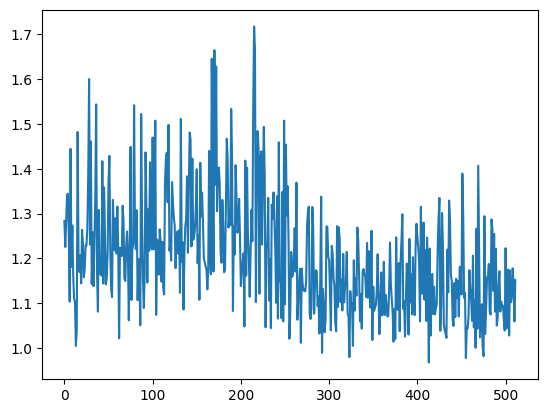

In [7]:
import matplotlib.pyplot as plt

# print(torch.stack(vectors).shape)
# Calculate the mean of the vectors
mean_vector = torch.mean(torch.stack(vectors), dim=0)


# Variance per dimension
variances = torch.var(torch.stack(vectors).view(-1, 512), dim=0)

# Plot variance per dimension
plt.plot(variances.cpu().numpy())
plt.show()


torch.Size([25800, 512])
Some vector norms:
tensor(25.9638, device='cuda:0')
tensor(25.9562, device='cuda:0')
tensor(25.9739, device='cuda:0')


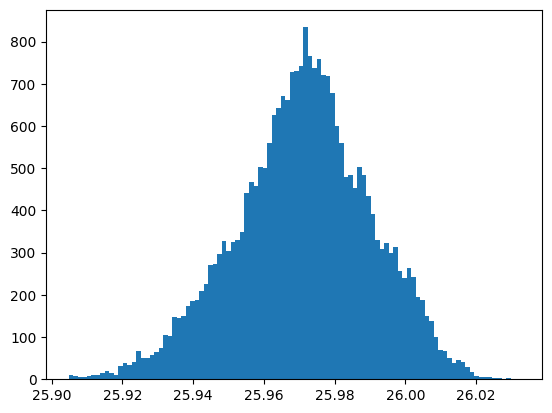

In [8]:
all_vectors = torch.stack(vectors).squeeze(0).reshape(-1, 512)

print(all_vectors.shape)
# Distribution of vector norms
norms = torch.norm(all_vectors, dim=1)

print("Some vector norms:")
print(norms[0])
print(norms[1])
print(norms[-1])

plt.hist(norms.cpu().numpy(), bins=100)
plt.show()





Percentage of similarities greater than 0.9:
0.25072 %


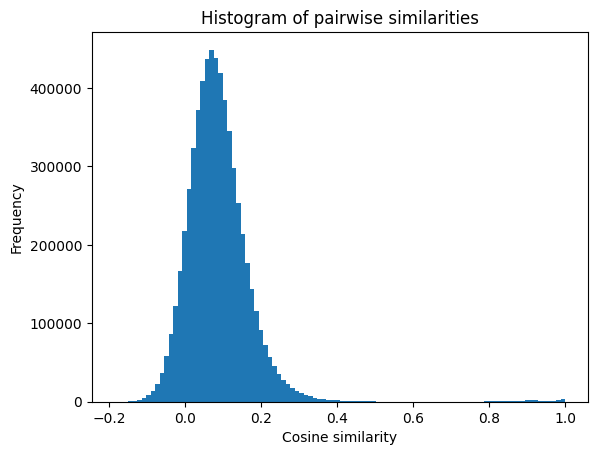

In [9]:
# Histogram of pairwise similarities

all_vectors_normalized = torch.nn.functional.normalize(all_vectors[:2500, :], dim=1, p=2)

similarities = all_vectors_normalized @ all_vectors_normalized.T


similarities = similarities.reshape(-1)

# similarities = torch.nn.functional.cosine_similarity(all_vectors, all_vectors, dim=1)

# print(similarities[0])

print("\n\nPercentage of similarities greater than 0.9:")
print(100 * torch.sum(similarities > 0.9).item() / len(similarities), "%")

plt.hist(similarities.cpu().numpy(), bins=100)
plt.title("Histogram of pairwise similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()




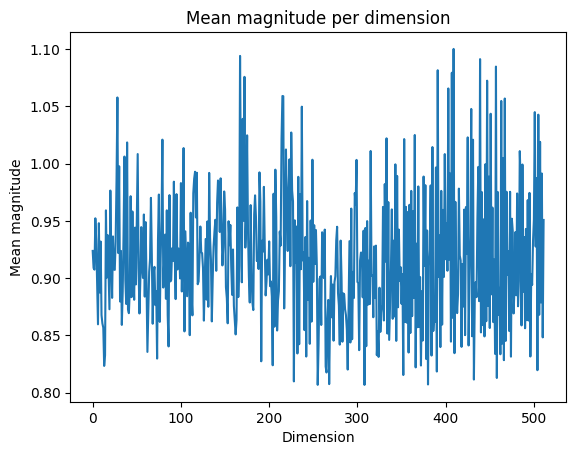

In [10]:
# Plot mean magnitude per dimension
mean_magnitude = torch.mean(torch.abs(all_vectors), dim=0)

plt.plot(mean_magnitude.cpu().numpy())
plt.title("Mean magnitude per dimension")
plt.xlabel("Dimension")
plt.ylabel("Mean magnitude")
plt.show()

## Semantic content

In [11]:
import random

midi_files = glob(os.path.join("/home/rafik/Documents/InnoUni/ai_lab/Sym-JEPA/dataset/clean_midi/", "**/*.mid"), recursive=True)

band_names = [os.path.dirname(f).split('/')[-1] for f in midi_files]

band_names = list(set(band_names))

# print(band_names)

# Pick ten random bands

bands = random.sample(band_names, 50)

print(bands)

# Get the midi files for the selected bands

per_band_midi_files = {band: [] for band in bands}

for midi_file in midi_files:
    band = os.path.dirname(midi_file).split('/')[-1]
    if band in bands:
        per_band_midi_files[band].append(midi_file)


# Remove bands with less than 8 midi files

per_band_midi_files = {band: files[:1] for band, files in per_band_midi_files.items() if len(files) >= 8}

for k, v in per_band_midi_files.items():
    print(k, len(v))


['Blood, Sweat & Tears', 'The Moody Blues', 'The Syndicate of Sound', 'T. Rex', 'Gounod Charles', 'The Brecker Brothers', 'Brandy', 'Eagles', 'Johnny Kemp', 'Dream Theater', 'The Folk Implosion', 'The Charmaines', 'The Smashing Pumpkins', 'Gloria Estefan', 'Edvard Grieg', 'Brotherhood of Man', 'Waller Fats', 'Atkins Chet', 'Lewis Ramsey', 'Quatro', 'Peter Cornelius', 'Mud', 'Macy Gray', 'Orbital', 'Nelson Oliver', 'REDDING OTIS', 'Astrud Gilberto', 'DaWN', 'Johnny Mathis', 'The Flying Pickets', 'George M. Cohan', "It's a Beautiful Day", 'Alison Moyet', 'Alvin Stardust', 'George Michael', 'Christie Lou', 'Lisa Stansfield', 'Trinere', 'First Class', 'Zero', 'Howard Jones', 'Just Friends', 'Interactive', 'Mink DeVille', 'Journey', 'George McCrae', 'Queensryche', 'Thin Lizzy', 'Roy Orbison', 'Rod Stewart']
Blood, Sweat & Tears 1
The Moody Blues 1
Eagles 1
The Smashing Pumpkins 1
Edvard Grieg 1
Atkins Chet 1
Zero 1
Journey 1
Queensryche 1
Roy Orbison 1
Rod Stewart 1


In [12]:
from tqdm import tqdm
per_band_dataset = {
    band: MidiDataset(files, max_len=2048, tokenization='octuple', group_bars=True, max_bars=512, max_positions=512, max_bars_per_context=-1, max_contexts_per_file=-1, bar_token_mask=None, bar_token_idx=2, use_cache=True, print_errors=False, tokenizer_class=OctupleTokenizer, use_mask_padding=False, genre_map_path='../metadata/midi_genre_map.json', skip_unknown_genres=False, skip_unknown_styles=False, sample_count_per_sequence=1) for band, files in per_band_midi_files.items()
    }

per_band_vectors = {}

for k, v in per_band_dataset.items():
    vectors = []
    n = 100
    jepa.eval()
    for i in tqdm(range(min(len(v), n))):
        with torch.no_grad():
            vectors.append(jepa.encode_context(v[i]['input_ids'].cuda().unsqueeze(0)))

        

    per_band_vectors[k] = torch.stack(vectors).squeeze(0).reshape(-1, 512)



    

100%|██████████| 9/9 [00:00<00:00, 28.87it/s]


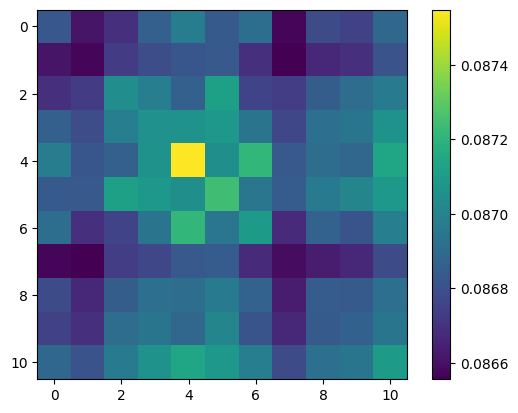

In [13]:
import matplotlib.pyplot as plt

def average_intergroup_similarity(a, b):
    a_norm = torch.nn.functional.normalize(a[:2000], dim=1, p=2)
    b_norm = torch.nn.functional.normalize(b[:2000], dim=1, p=2)

    similarities = a_norm @ b_norm.T

    return similarities.view(-1).mean()





similarity_matrix = []

for k, v in per_band_vectors.items():
    similarity_matrix.append([])
    for x, y in per_band_vectors.items():
        similarity_matrix[-1].append(average_intergroup_similarity(v, y).item())



# print(similarity_matrix)

# Plot the similarity matrix

plt.imshow(similarity_matrix)
plt.colorbar()
plt.show()



